<a href="https://colab.research.google.com/github/DungDuong1002/Photo-Colorization/blob/main/autoencoder_color.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.layers import MaxPool2D,Conv2D,UpSampling2D,Input,Dropout
from keras.models import Sequential
from keras.preprocessing.image import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 160
color_img = []
gray_img = []
path = '/content/drive/MyDrive/landscape Images/color_2k'
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
#    if i == '5000.jpg':
#        break
#    else:    
  img1 = cv2.imread(path + '/'+i,1)
# open cv reads images in BGR format so we have to convert it to RGB
  img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
#resizing image
  img1 = cv2.resize(img1, (SIZE, SIZE))
  img1 = img1.astype('float32') / 255.0
  color_img.append(img_to_array(img1))

  img2 = cv2.imread(path + '/'+i,0)
# open cv reads images in BGR format so we have to convert it to RGB
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
#resizing image
  img2 = cv2.resize(img2, (SIZE, SIZE))
  img2 = img2.astype('float32') / 255.0
  gray_img.append(img_to_array(img2))

In [ ]:
# defining function to plot images pair
def plot_images(color,grayscale):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image')
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image')
    plt.imshow(grayscale)
   
    plt.show()

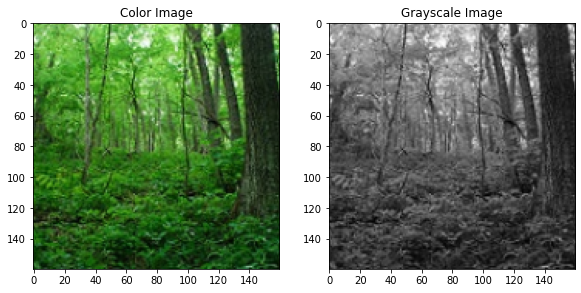

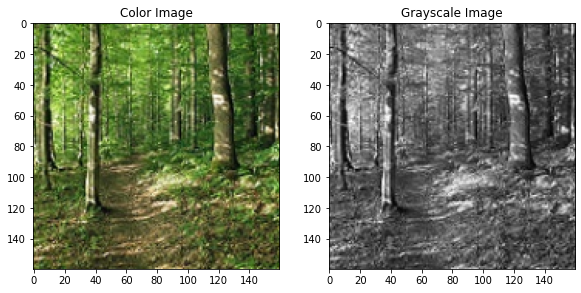

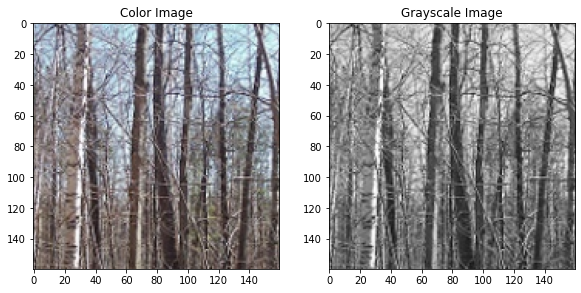

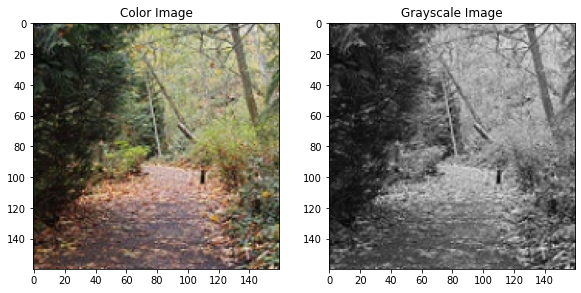

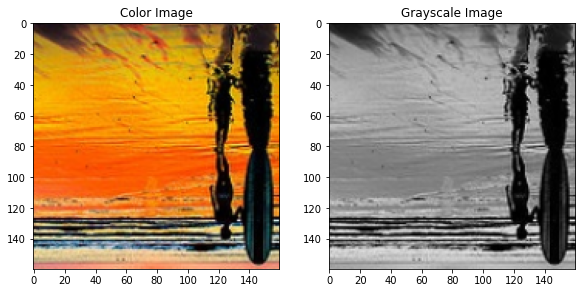

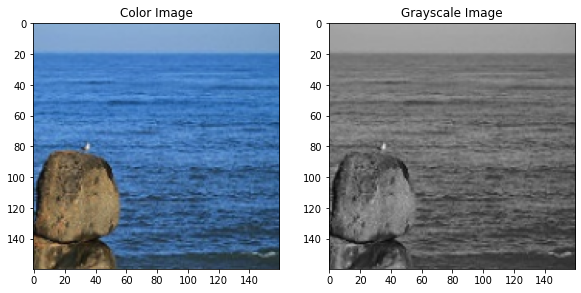

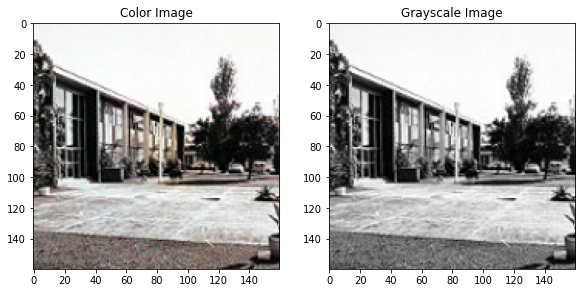

In [ ]:
for i in range(3,10):
     plot_images(color_img[i],gray_img[i])

In [ ]:
train_gray_image = gray_img[:1900]
train_color_image = color_img[:1900]

test_gray_image = gray_img[1900:]
test_color_image = color_img[1900:]
# reshaping
train_gray = np.reshape(train_gray_image,(len(train_gray_image),SIZE,SIZE,3))
train_color = np.reshape(train_color_image, (len(train_color_image),SIZE,SIZE,3))
print('Train color image shape:',train_c.shape)


test_gray_image = np.reshape(test_gray_image,(len(test_gray_image),SIZE,SIZE,3))
test_color_image = np.reshape(test_color_image, (len(test_color_image),SIZE,SIZE,3))
print('Test color image shape',test_color_image.shape)

Train color image shape: (1900, 160, 160, 3)
Test color image shape (229, 160, 160, 3)


In [ ]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample

def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

In [ ]:
def model():
    #downsampling
    inputs = layers.Input(shape= [160,160,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    d5 = down(512,(3,3),True)(d4)
    
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [ ]:
model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 80, 80, 128)  3584        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 40, 40, 128)  147584      sequential[0][0]                 
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 20, 20, 256)  296192      sequential_1[0][0]               
______________________________________________________________________________________________

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = 'mean_absolute_error',
              metrics = ['acc'])

model.fit(train_gray, train_color, epochs = 50,batch_size = 20,verbose = 1)

Epoch 1/50
62/95 [==================>...........] - ETA: 2:38 - loss: 0.1433 - acc: 0.3527

In [ ]:
score=model.evaluate(test_gray_image,test_color_image)

16/16 [==============================] - 3s 125ms/step - loss: 0.0480 - acc: 0.5663


[0.047954630106687546, 0.5663182139396667]

In [ ]:
# defining function to plot images pair
def plot_images(color,grayscale,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('Color Image')
    plt.imshow(color)
    plt.subplot(1,3,2)
    plt.title('Grayscale Image ')
    plt.imshow(grayscale)
    plt.subplot(1,3,3)
    plt.title('Predicted Image ')
    plt.imshow(predicted)
   
    plt.show()

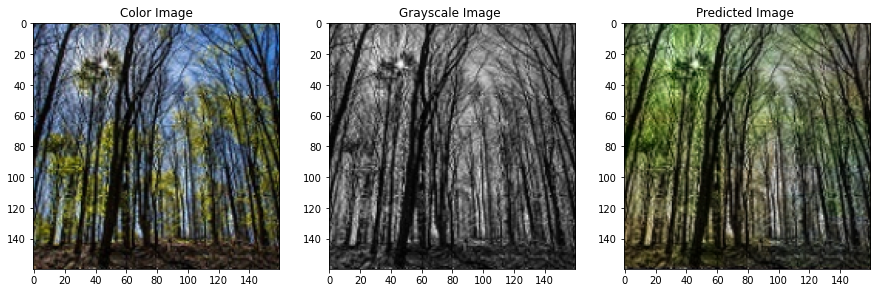

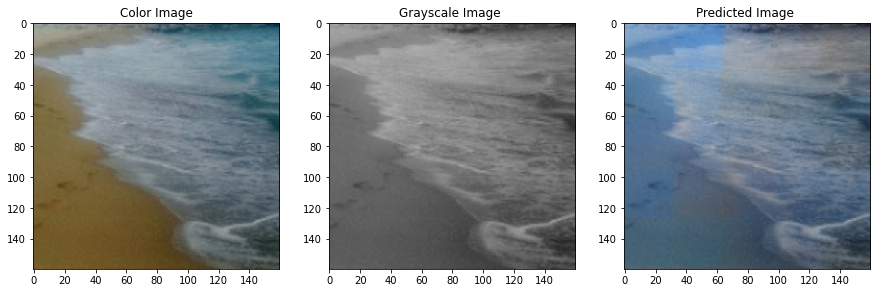

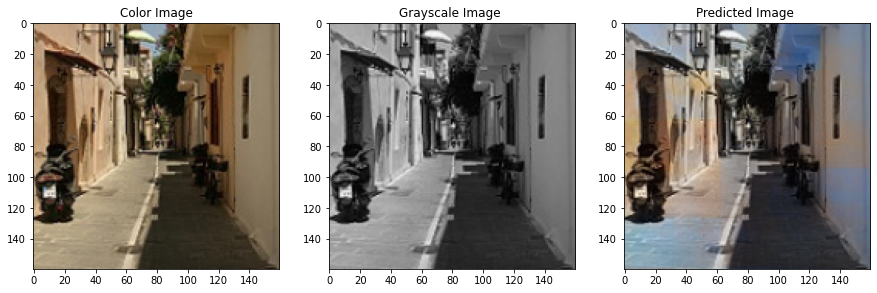

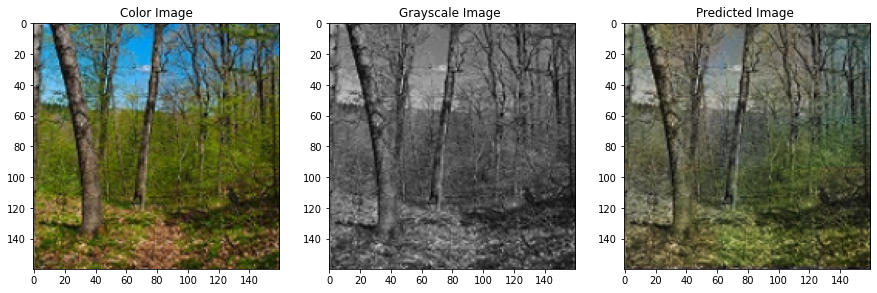

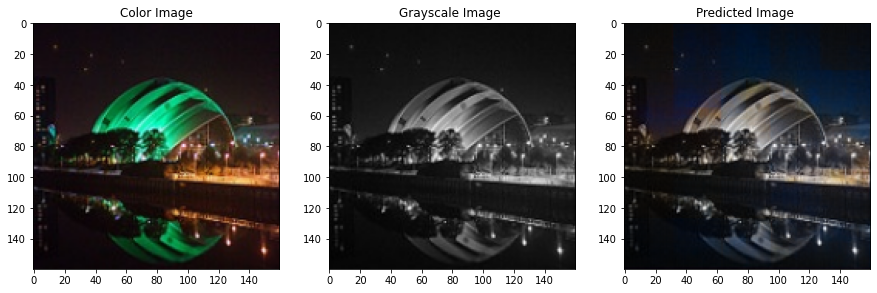

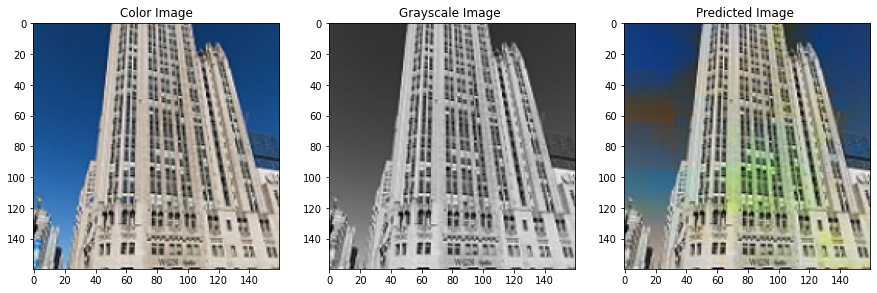

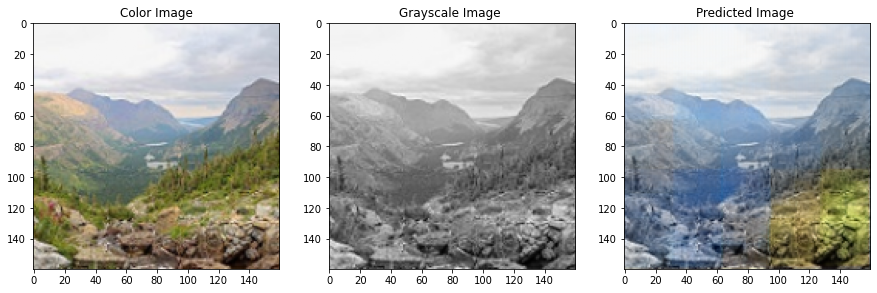

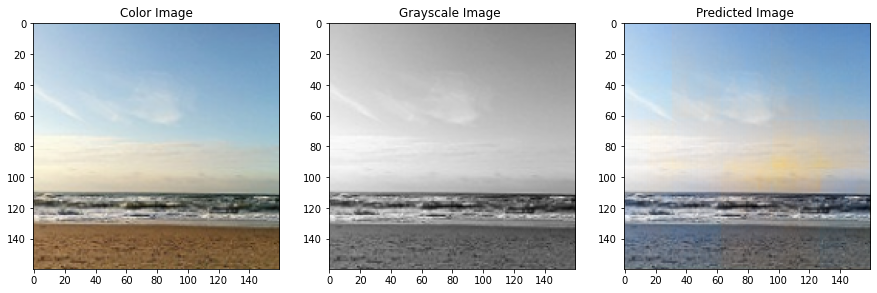

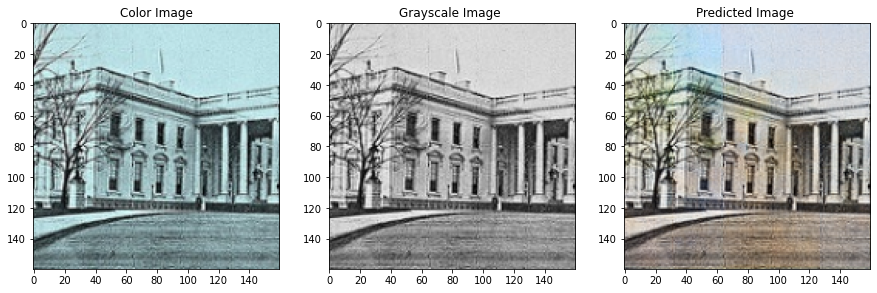

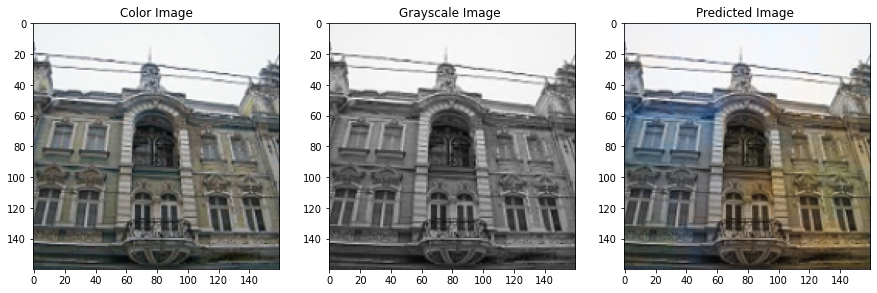

In [ ]:
for i in range(10,20):
    predicted = np.clip(model.predict(test_gray_image[i].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_color_image[i],test_gray_image[i],predicted)

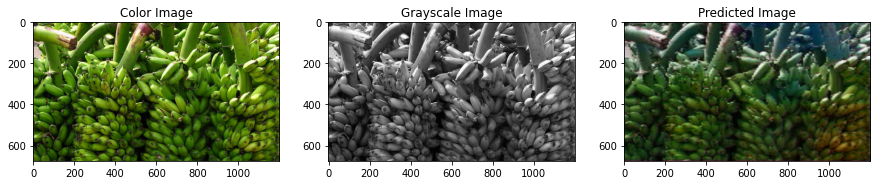

In [ ]:
# test other source images
path = '/content/1280px-India_-_Koyambedu_Market_-_Banana_08_3986943802.jpg'
img = cv2.imread(path)
color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
grayscale = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
grayscale = cv2.cvtColor(grayscale, cv2.COLOR_BGR2RGB)
h = img.shape[0]
w = img.shape[1]
SIZE=160
#resizing image
img = cv2.resize(img, (SIZE, SIZE))
img = img.astype('float32') / 255.0

predicted = np.clip(model.predict(img_to_array(img).reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
predicted = cv2.resize(predicted, (w,h))
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.title('Color Image')
plt.imshow(color)
plt.subplot(1,3,2)
plt.title('Grayscale Image')
plt.imshow(grayscale)
plt.subplot(1,3,3)
plt.title('Predicted Image')
plt.imshow(predicted)

In [ ]:
def colorize_image(path):
  img = cv2.imread(path)
  grayscale = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
  grayscale = cv2.cvtColor(grayscale, cv2.COLOR_BGR2RGB)
  h = img.shape[0]
  w = img.shape[1]
  SIZE=160
  #resizing image
  img = cv2.resize(img, (SIZE, SIZE))
  img = img.astype('float32') / 255.0

  colorized = np.clip(model.predict(img_to_array(img).reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
  colorized = cv2.resize(colorized, (w,h))
  colorized = np.clip(colorized, 0, 1)
  # the current colorized image is represented as a floating point data type in the range [0, 1] -- let's convert to an unsigned 8-bit integer representation in the range [0, 255]
  colorized = (255 * colorized).astype("uint8")
  return grayscale, colorized

In [ ]:
model.save('autoencoder_color.h5')